--- 
title: PA 7.2
author: Isabelle Antaran
format:
    html:
        toc: true
        code-fold: true
        embed-resources: true
theme: flatly
---


In [46]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import plotnine as p9

In [47]:
housing = pd.read_csv("../Data/AmesHousing.csv")
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [48]:
# Delete columns with mostly NaN values 
good_cols = housing.isna().sum() < 100
housing = housing.loc[:, good_cols]

# Drop other NAs
housing = housing.dropna()

In [49]:
# Define X and y
X = housing.drop(["SalePrice", "Order", "PID"], axis = 1) #features
y = housing["SalePrice"] #target

In [6]:
X.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,4,2010,WD,Normal
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal


In [9]:
y.head()

0    215000
1    105000
2    172000
3    244000
4    189900
Name: SalePrice, dtype: int64

In [50]:
# Automatically identify numerical and categorical features
num_sel = make_column_selector(dtype_include=np.number)
cat_sel = make_column_selector(dtype_exclude=np.number)

numeric_features = num_sel(X)
categorical_features = cat_sel(X)

In [19]:
print(f"Numerical features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numerical features: 34
Categorical features: 33


In [53]:
# Preprocessing Pipeline
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_scaling', StandardScaler(), numeric_features),
        ('categorical_encoding', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Model 1: OLS Regression

In [ ]:
# Create OLS pipeline
ols_pipeline = Pipeline([
    ('preprocessing', data_preprocessor),
    ('linear_model', LinearRegression())
])

# Perform 5-fold cross-validation
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)
ols_cv_scores = cross_val_score(
    ols_pipeline, X, y, 
    cv=cv_splitter, 
    scoring='r2'
)

In [54]:
# Fit model on full data to extract coefficients
ols_pipeline.fit(X, y)
ols_feature_names = ols_pipeline.named_steps['preprocessing'].get_feature_names_out().tolist()
ols_coefficients = pd.Series(
    ols_pipeline.named_steps['linear_model'].coef_, 
    index=ols_feature_names, 
    name='OLS'
)

In [55]:
print(f"Cross-validated R² (mean ± sd): {ols_cv_scores.mean():.4f} ± {ols_cv_scores.std():.4f}")

Cross-validated R² (mean ± sd): 0.8250 ± 0.0247


# Model 2: Ridge Regression (L2 Regularization)

In [30]:
# Create Ridge pipeline with alpha=1
ridge_pipeline = Pipeline([
    ('preprocessing', data_preprocessor),
    ('ridge_model', Ridge(alpha=1.0, random_state=42))
])

# Perform 5-fold cross-validation
ridge_cv_scores = cross_val_score(
    ridge_pipeline, X, y, 
    cv=cv_splitter, 
    scoring='r2'
)

# Fit model to extract coefficients
ridge_pipeline.fit(X, y)
ridge_feature_names = ridge_pipeline.named_steps['preprocessing'].get_feature_names_out().tolist()
ridge_coefficients = pd.Series(
    ridge_pipeline.named_steps['ridge_model'].coef_, 
    index=ridge_feature_names, 
    name='Ridge'
)

print(f"Cross-validated R² (mean ± sd): {ridge_cv_scores.mean():.4f} ± {ridge_cv_scores.std():.4f}")

Cross-validated R² (mean ± sd): 0.8657 ± 0.0405


# Coefficient Comparison: OLS vs Ridge 

In [ ]:
# Combine coefficients for comparison
ols_ridge_comparison = pd.concat([ols_coefficients, ridge_coefficients], axis=1)
ols_ridge_comparison = (
    ols_ridge_comparison
    .reset_index()
    .melt(id_vars='index', var_name='Model', value_name='Coefficient')
    .rename(columns={'index': 'Feature'})
)

# Get top 40 features by absolute coefficient value
top_features_ols_ridge = (
    ols_ridge_comparison
    .groupby('Feature')['Coefficient']
    .apply(lambda x: x.abs().max())
    .sort_values(ascending=False)
    .head(40)
    .index
)

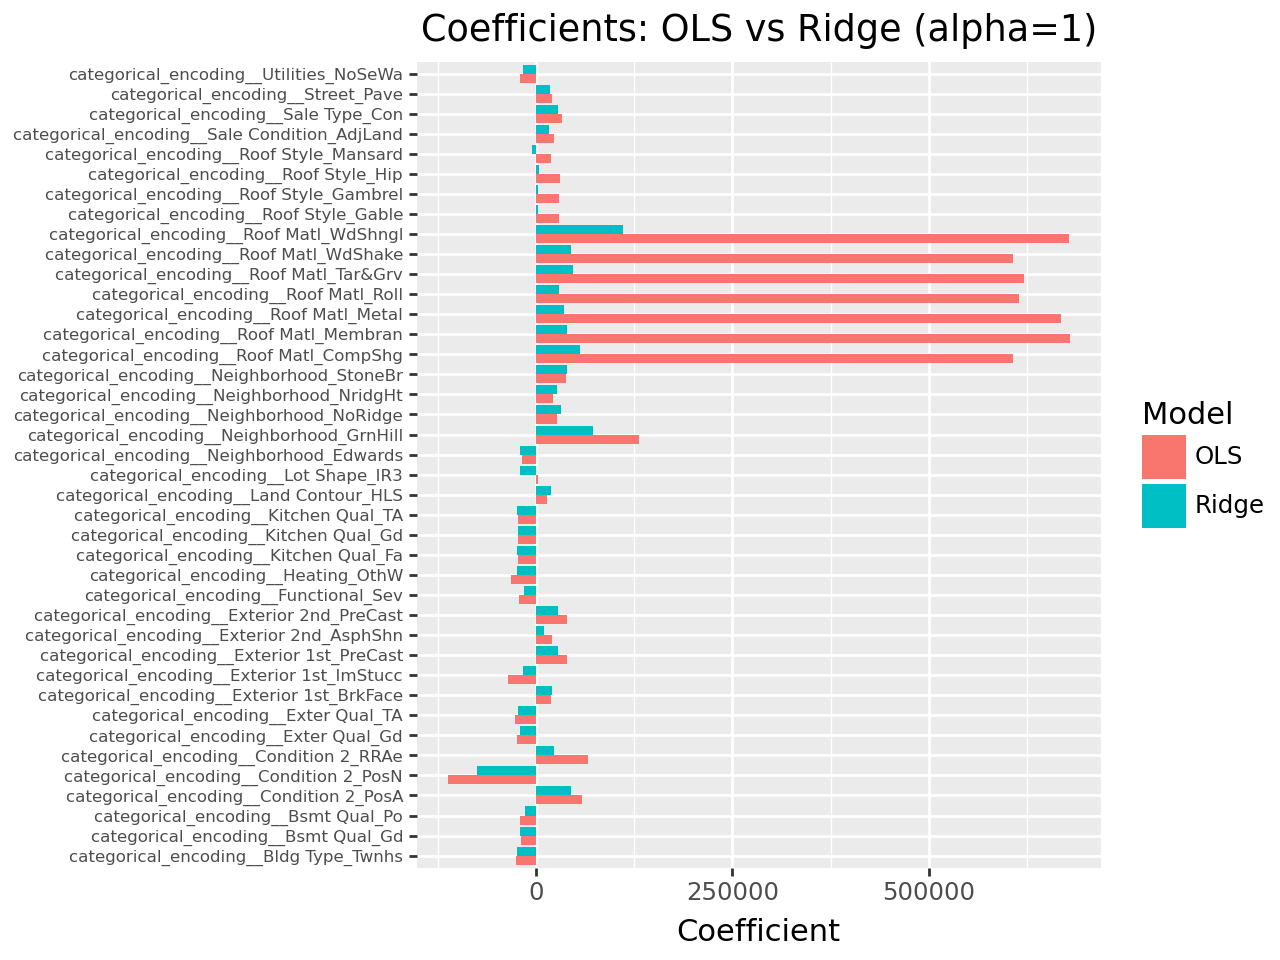

In [34]:
# Plot comparison
plot_ols_ridge = (
    p9.ggplot(
        ols_ridge_comparison[ols_ridge_comparison['Feature'].isin(top_features_ols_ridge)],
        p9.aes(x='Feature', y='Coefficient', fill='Model')
    )
    + p9.geom_col(position='dodge')
    + p9.coord_flip()
    + p9.labs(title='Coefficients: OLS vs Ridge (alpha=1)', x='', y='Coefficient')
    + p9.theme(axis_text_y=p9.element_text(size=6))
)

plot_ols_ridge.show()

# Model 3: Lasso Regression - L1 Regularization with Tuning

In [56]:
# Create LASSO pipeline
lasso_pipeline = Pipeline([
    ('preprocessing', data_preprocessor),
    ('lasso_model', Lasso(max_iter=5000, random_state=42))
])

# Define parameter grid
lasso_param_grid = {
    'lasso_model__alpha': np.logspace(-3, 2, 30)
}

# Perform grid search 
lasso_grid_search = GridSearchCV(
    lasso_pipeline, 
    lasso_param_grid, 
    scoring='r2', 
    cv=cv_splitter, 
    n_jobs=-1
)

lasso_grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical_scaling',
                                                                         StandardScaler(),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'Lot '
                                                                          'Area',
                                                                          'Overall '
                                                                          'Qual',
                                                                          'Overall '
                                                                          'Cond',
                                                                          'Year '
                                                                          'Built',
                                                                          'Year '
                                                                          'Remod/Add',
                                                                          'Mas '
                                                                          'Vnr '
                                                                          'Area',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '1',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '2',
                                                                          'Bsmt '
                                                                          'Unf '
                                                                          'SF',
                                                                          'Total '
                                                                          'Bsmt '
                                                                          'S...
       4.89390092e-03, 7.27895384e-03, 1.08263673e-02, 1.61026203e-02,
       2.39502662e-02, 3.56224789e-02, 5.29831691e-02, 7.88046282e-02,
       1.17210230e-01, 1.74332882e-01, 2.59294380e-01, 3.85662042e-01,
       5.73615251e-01, 8.53167852e-01, 1.26896100e+00, 1.88739182e+00,
       2.80721620e+00, 4.17531894e+00, 6.21016942e+00, 9.23670857e+00,
       1.37382380e+01, 2.04335972e+01, 3.03919538e+01, 4.52035366e+01,
       6.72335754e+01, 1.00000000e+02])},
             scoring='r2')

In [37]:
print(f"Best LASSO alpha: {lasso_grid_search.best_params_['lasso_model__alpha']:.6f}")
print(f"Best LASSO CV R²: {lasso_grid_search.best_score_:.4f}")

# Extract best model coefficients
lasso_best_model = lasso_grid_search.best_estimator_
lasso_feature_names = lasso_best_model.named_steps['preprocessing'].get_feature_names_out().tolist()
lasso_coefficients = pd.Series(
    lasso_best_model.named_steps['lasso_model'].coef_, 
    index=lasso_feature_names, 
    name='LASSO'
)

Best LASSO alpha: 45.203537
Best LASSO CV R²: 0.8683


# Coefficient Comparison: OLS vs Ridge vs Lasso

In [38]:
# Combine all three coefficient sets
ols_ridge_lasso_comparison = pd.concat([ols_coefficients, ridge_coefficients, lasso_coefficients], axis=1)
ols_ridge_lasso_comparison = (
    ols_ridge_lasso_comparison
    .reset_index()
    .melt(id_vars='index', var_name='Model', value_name='Coefficient')
    .rename(columns={'index': 'Feature'})
)

# Get top features
top_features_three_models = (
    ols_ridge_lasso_comparison
    .groupby('Feature')['Coefficient']
    .apply(lambda x: x.abs().max())
    .sort_values(ascending=False)
    .head(40)
    .index
)

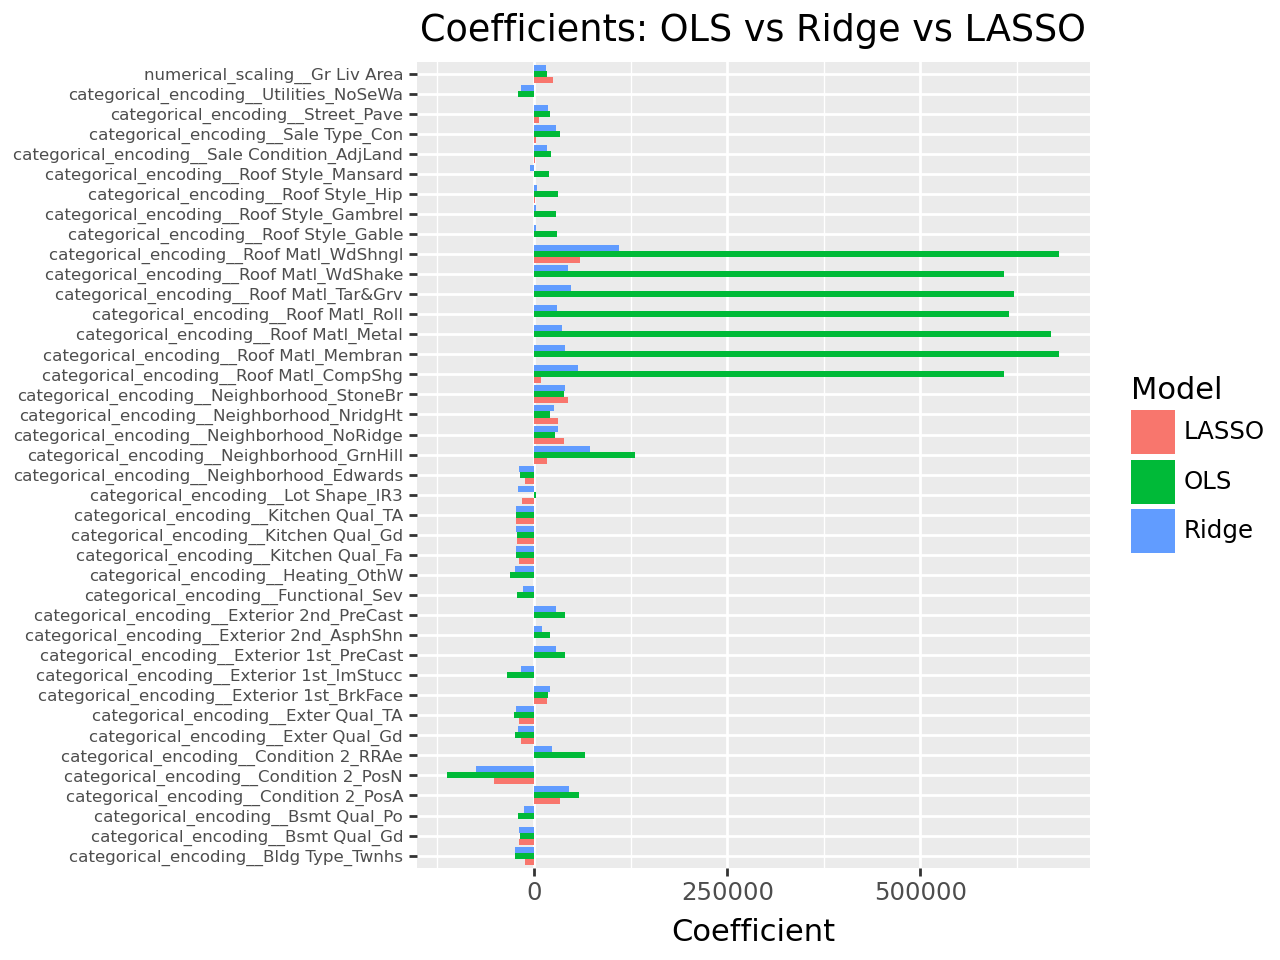

In [40]:
# Plot three-way comparison
plot_three_models = (
    p9.ggplot(
        ols_ridge_lasso_comparison[ols_ridge_lasso_comparison['Feature'].isin(top_features_three_models)],
        p9.aes(x='Feature', y='Coefficient', fill='Model')
    )
    + p9.geom_col(position='dodge')
    + p9.coord_flip()
    + p9.labs(title='Coefficients: OLS vs Ridge vs LASSO', x='', y='Coefficient')
    + p9.theme(axis_text_y=p9.element_text(size=6))
)

plot_three_models.show()


# Model 4: Elastic Net (L1 + L2 Regularization) with Tuning

In [41]:
# Create Elastic Net pipeline
elasticnet_pipeline = Pipeline([
    ('preprocessing', data_preprocessor),
    ('elasticnet_model', ElasticNet(max_iter=5000, random_state=42))
])

# Define parameter grid for alpha and l1_ratio tuning
elasticnet_param_grid = {
    'elasticnet_model__alpha': np.logspace(-3, 2, 15),
    'elasticnet_model__l1_ratio': np.linspace(0.05, 0.95, 10)
}

# Perform grid search
elasticnet_grid_search = GridSearchCV(
    elasticnet_pipeline, 
    elasticnet_param_grid, 
    scoring='r2', 
    cv=cv_splitter, 
    n_jobs=-1
)

elasticnet_grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical_scaling',
                                                                         StandardScaler(),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'Lot '
                                                                          'Area',
                                                                          'Overall '
                                                                          'Qual',
                                                                          'Overall '
                                                                          'Cond',
                                                                          'Year '
                                                                          'Built',
                                                                          'Year '
                                                                          'Remod/Add',
                                                                          'Mas '
                                                                          'Vnr '
                                                                          'Area',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '1',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '2',
                                                                          'Bsmt '
                                                                          'Unf '
                                                                          'SF',
                                                                          'Total '
                                                                          'Bsmt '
                                                                          'S...
             param_grid={'elasticnet_model__alpha': array([1.00000000e-03, 2.27584593e-03, 5.17947468e-03, 1.17876863e-02,
       2.68269580e-02, 6.10540230e-02, 1.38949549e-01, 3.16227766e-01,
       7.19685673e-01, 1.63789371e+00, 3.72759372e+00, 8.48342898e+00,
       1.93069773e+01, 4.39397056e+01, 1.00000000e+02]),
                         'elasticnet_model__l1_ratio': array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])},
             scoring='r2')

In [44]:
print(f"Best Elastic Net params: {elasticnet_grid_search.best_params_}")
print(f"Best Elastic Net CV R²: {elasticnet_grid_search.best_score_:.4f}")


Best Elastic Net params: {'elasticnet_model__alpha': np.float64(0.005179474679231213), 'elasticnet_model__l1_ratio': np.float64(0.44999999999999996)}
Best Elastic Net CV R²: 0.8676


In [45]:
# Extract best model coefficients
elasticnet_best_model = elasticnet_grid_search.best_estimator_
elasticnet_feature_names = elasticnet_best_model.named_steps['preprocessing'].get_feature_names_out().tolist()
elasticnet_coefficients = pd.Series(
    elasticnet_best_model.named_steps['elasticnet_model'].coef_, 
    index=elasticnet_feature_names, 
    name='ElasticNet'
)

# Coefficient Comparison: All Models

In [43]:
# Combine all four coefficient sets
all_models_comparison = pd.concat([
    ols_coefficients, 
    ridge_coefficients, 
    lasso_coefficients, 
    elasticnet_coefficients
], axis=1)

all_models_comparison = (
    all_models_comparison
    .reset_index()
    .melt(id_vars='index', var_name='Model', value_name='Coefficient')
    .rename(columns={'index': 'Feature'})
)

# Get top features across all models
top_features_all_models = (
    all_models_comparison
    .groupby('Feature')['Coefficient']
    .apply(lambda x: x.abs().max())
    .sort_values(ascending=False)
    .head(40)
    .index
)

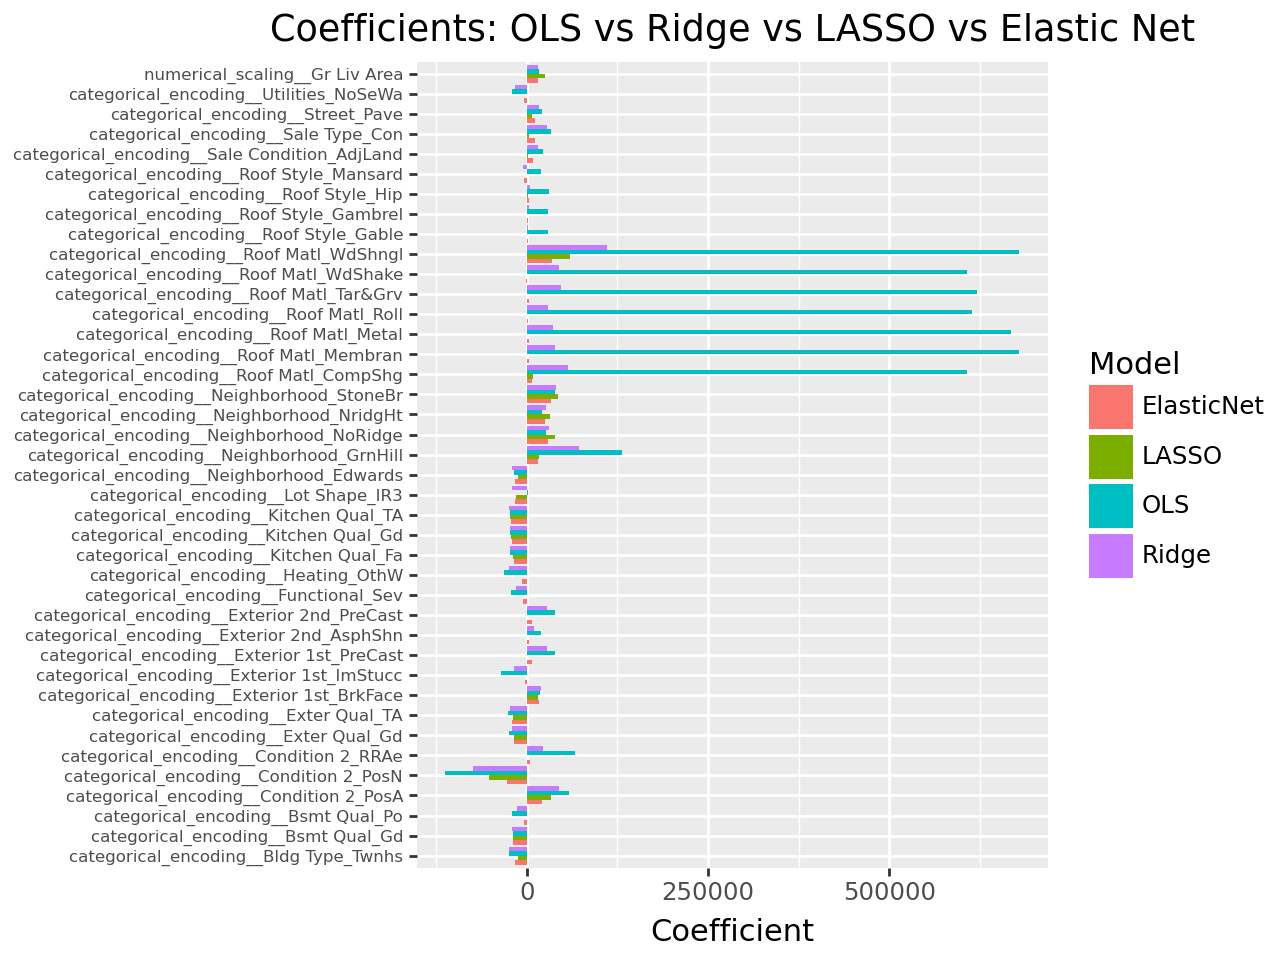

In [57]:
# Create final comparison plot
plot_all_models = (
    p9.ggplot(
        all_models_comparison[all_models_comparison['Feature'].isin(top_features_all_models)],
        p9.aes(x='Feature', y='Coefficient', fill='Model')
    )
    + p9.geom_col(position='dodge')
    + p9.coord_flip()
    + p9.labs(title='Coefficients: OLS vs Ridge vs LASSO vs Elastic Net', x='', y='Coefficient')
    + p9.theme(axis_text_y=p9.element_text(size=6))
)

plot_all_models.show()